In [45]:

import os
import cv2
import numpy as np
from pycocotools.coco import COCO
from torch.utils.data import Dataset

import albumentations
from albumentations.pytorch import ToTensorV2


from PIL import Image, ImageOps, ImageEnhance
from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.core.transforms_interface import DualTransform, DualTransformCustom
from albumentations.augmentations import functional as F


import matplotlib.pyplot as plt
import torch

from torch.utils.data import DataLoader
from utils import label_accuracy_score, add_hist, class_colormap, label_to_color_image

%matplotlib inline
from matplotlib.patches import Patch
import webcolors


In [47]:

dataset_path = '/opt/ml/segmentation/semantic-segmentation-level2-cv-06/input/data/'
category_names = ['Background', 'General trash', 'Paper', 'Paper pack', 'Metal', 'Glass',
                  'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']


def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id'] == classID:
            return cats[i]['name']
    return "None"


class CustomDataLoader(Dataset):
    """
    coco format
    """
    def __init__(self, data_dir, mode='train', transform=None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)

        # Load the categories in a variable
        self.cat_ids = self.coco.getCatIds()
        self.cats = self.coco.loadCats(self.cat_ids)
    
    def __getitem__(self, index):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]

        # cv2를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0

        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))

            # General trash = 1, ... , Clothing = 10
            # anns = sorted(anns, key=lambda idx: len(idx['segmentation'][0]), reverse=True)
            anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)
            
            for i in range(len(anns)):
                # className = get_classname(anns[i]['category_id'], self.cats)
                # pixel_value = category_names.index(className)
                # masks[self.coco.annToMask(anns[i])==1] = pixel_value
                masks[self.coco.annToMask(anns[i])==1] = anns[i]['category_id']
            masks = masks.astype(np.int8)

            # [기존] transform -> albumentations
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]


            # [변경] transform -> albumentations
            # if self.transform is not None:
            #     transformed = self.transform(imageAndMask=[images, masks])
            #     images, masks = transformed["imageAndMask"]
            # images = (torch.from_numpy(images)).permute([2,0,1])
            # masks = torch.from_numpy(masks)

            return images, masks, image_infos
        elif self.mode == 'test':
            # transform -> albumentations
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            return images, image_infos
        else:
            raise RuntimeError("CustomDataLoader mode error")
    
    def __len__(self):
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())


def collate_fn(batch):
    return tuple(zip(*batch))


# mask도 같이 Augment1

In [48]:

# def int_parameter(level, maxval):
#     """Helper function to scale `val` between 0 and maxval .
#     Args:
#     level: Level of the operation that will be between [0, `PARAMETER_MAX`].
#     maxval: Maximum value that the operation can have. This will be scaled to
#       level/PARAMETER_MAX.
#     Returns:
#     An int that results from scaling `maxval` according to `level`.
#     """
#     return int(level * maxval / 10)


# def float_parameter(level, maxval):
#     """Helper function to scale `val` between 0 and maxval.
#     Args:
#     level: Level of the operation that will be between [0, `PARAMETER_MAX`].
#     maxval: Maximum value that the operation can have. This will be scaled to
#       level/PARAMETER_MAX.
#     Returns:
#     A float that results from scaling `maxval` according to `level`.
#     """
#     return float(level) * maxval / 10.


# def sample_level(n):
#     return np.random.uniform(low=0.1, high=n)


# def autocontrast(pil_img, pil_mask, _):
#     return ImageOps.autocontrast(pil_img), pil_mask


# def equalize(pil_img, pil_mask, _):
#     return ImageOps.equalize(pil_img), pil_mask


# def posterize(pil_img, pil_mask, level):
#     level = int_parameter(sample_level(level), 4)
#     return ImageOps.posterize(pil_img, 4 - level), pil_mask


# def rotate(pil_img, pil_mask, level):
#     degrees = int_parameter(sample_level(level), 30)
#     if np.random.uniform() > 0.5:
#         degrees = -degrees
#     return pil_img.rotate(degrees + 30, resample=Image.BILINEAR), pil_mask.rotate(degrees + 30, resample=Image.BILINEAR)


# def solarize(pil_img, pil_mask, level):
#     level = int_parameter(sample_level(level), 256)
#     return ImageOps.solarize(pil_img, 256 - level),  pil_mask


# def shear_x(pil_img, pil_mask, level):
#     level = float_parameter(sample_level(level), 0.3)
#     if np.random.uniform() > 0.5:
#         level = -level
#     return pil_img.transform(pil_img.size,Image.AFFINE, (1, level, 0, 0, 1, 0), resample=Image.BILINEAR), \
#            pil_mask.transform(pil_mask.size, Image.AFFINE, (1, level, 0, 0, 1, 0), resample=Image.BILINEAR)
                           


# def shear_y(pil_img, pil_mask, level):
#     level = float_parameter(sample_level(level), 0.3)
#     if np.random.uniform() > 0.5:
#         level = -level
#     return pil_img.transform(pil_img.size, Image.AFFINE, (1, 0, 0, level, 1, 0), resample=Image.BILINEAR), \
#            pil_mask.transform(pil_mask.size, Image.AFFINE, (1, 0, 0, level, 1, 0), resample=Image.BILINEAR),


# def translate_x(pil_img, pil_mask, level):
#     level = int_parameter(sample_level(level), pil_img.size[0] / 3)
#     if np.random.random() > 0.5:
#         level = -level
#     return pil_img.transform(pil_img.size, Image.AFFINE, (1, 0, level, 0, 1, 0), resample=Image.BILINEAR), \
#            pil_mask.transform(pil_mask.size, Image.AFFINE, (1, 0, level, 0, 1, 0), resample=Image.BILINEAR)


# def translate_y(pil_img, pil_mask, level):
#     level = int_parameter(sample_level(level), pil_img.size[0] / 3)
#     if np.random.random() > 0.5:
#         level = -level
#     return pil_img.transform(pil_img.size,Image.AFFINE, (1, 0, 0, 0, 1, level),resample=Image.BILINEAR), \
#           pil_mask.transform(pil_mask.size,Image.AFFINE, (1, 0, 0, 0, 1, level),resample=Image.BILINEAR)


# # operation that overlaps with ImageNet-C's test set
# def color(pil_img, pil_mask, level):
#     level = float_parameter(sample_level(level), 1.8) + 0.1
#     return ImageEnhance.Color(pil_img).enhance(level), pil_mask


# # operation that overlaps with ImageNet-C's test set
# def contrast(pil_img, pil_mask, level):
#     level = float_parameter(sample_level(level), 1.8) + 0.1
#     return ImageEnhance.Contrast(pil_img).enhance(level), pil_mask


# # operation that overlaps with ImageNet-C's test set
# def brightness(pil_img, pil_mask, level):
#     level = float_parameter(sample_level(level), 1.8) + 0.1
#     return ImageEnhance.Brightness(pil_img).enhance(level), pil_mask


# # operation that overlaps with ImageNet-C's test set
# def sharpness(pil_img, pil_mask, level):
#     level = float_parameter(sample_level(level), 1.8) + 0.1
#     return ImageEnhance.Sharpness(pil_img).enhance(level), pil_mask


# # augmentations = [
# #     autocontrast, 
# #     equalize, 
# #     posterize, rotate, 
# #     solarize, 
# #     shear_x, shear_y,
# #     translate_x, translate_y
# # ]

# augmentations_all = [
#     autocontrast, equalize, posterize, 
#     rotate, 
#     solarize, 
#     shear_x, shear_y,
#     translate_x, translate_y, 
#     color, contrast, 
#     brightness, sharpness
# ]

# def normalize(image):
#     """Normalize input image channel-wise to zero mean and unit variance."""
#     return image - 127

# def apply_op(image, mask, op, severity):
#     #   image = np.clip(image, 0, 255)
#     image = image * 255
#     image = image.astype(np.uint8)

#     pil_img = Image.fromarray(image)  # Convert to PIL.Image
#     pil_mask = Image.fromarray(mask)  # Convert to PIL.Image
    
#     pil_img, pil_mask = op(pil_img, pil_mask, severity)
#     return np.asarray(pil_img), np.asarray(pil_mask)

# def augment_and_mix(image, severity=3, width=3, depth=-1, alpha=1., mask=None):
#     """Perform AugMix augmentations and compute mixture.
#     Args:
#     image: Raw input image as float32 np.ndarray of shape (h, w, c)
#     severity: Severity of underlying augmentation operators (between 1 to 10).
#     width: Width of augmentation chain
#     depth: Depth of augmentation chain. -1 enables stochastic depth uniformly
#       from [1, 3]
#     alpha: Probability coefficient for Beta and Dirichlet distributions.
#     Returns:
#     mixed: Augmented and mixed image.
#     """
#     ws = np.float32(
#       np.random.dirichlet([alpha] * width))
#     m = np.float32(np.random.beta(alpha, alpha))

#     # mix = np.zeros_like(image).astype(np.float32)
#     mix = image
#     for i in range(width):
#         image_aug = image.copy()
#         mask_aug = mask.copy()
#         depth = depth if depth > 0 else np.random.randint(1, 4)
#         for _ in range(depth):
#             op = np.random.choice(augmentations_all)
#             image_aug, mask_aug = apply_op(image_aug, mask_aug, op, severity)
#         # Preprocessing commutes since all coefficients are convex
#         mix += ws[i] * image_aug
# #         mix += ws[i] * normalize(image_aug)


#     # m = 0.2
    
#     mixed = (1 - m) * image + m * mix
# #     mixed = (1 - m) * normalize(image) + m * mix
#     mixed /= 255

#     return mixed, mask_aug


# class RandomAugMix(DualTransformCustom):

#     def __init__(self, severity=3, width=3, depth=-1, alpha=1., always_apply=False, p=0.5):
#         super().__init__(always_apply, p)
#         self.severity = severity
#         self.width = width
#         self.depth = depth
#         self.alpha = alpha
        
#     def apply(self, image, **params):
#         image, mask = image
#         image, mask = augment_and_mix(
#             image,
#             self.severity,
#             self.width,
#             self.depth,
#             self.alpha,
#             mask
#         )
#         return image, mask



# Mask도 같이 augment 2

In [49]:
# def int_parameter(level, maxval):
#     """Helper function to scale `val` between 0 and maxval .
#     Args:
#     level: Level of the operation that will be between [0, `PARAMETER_MAX`].
#     maxval: Maximum value that the operation can have. This will be scaled to
#       level/PARAMETER_MAX.
#     Returns:
#     An int that results from scaling `maxval` according to `level`.
#     """
#     return int(level * maxval / 10)


# def float_parameter(level, maxval):
#     """Helper function to scale `val` between 0 and maxval.
#     Args:
#     level: Level of the operation that will be between [0, `PARAMETER_MAX`].
#     maxval: Maximum value that the operation can have. This will be scaled to
#       level/PARAMETER_MAX.
#     Returns:
#     A float that results from scaling `maxval` according to `level`.
#     """
#     return float(level) * maxval / 10.


# def sample_level(n):
#     return np.random.uniform(low=0.1, high=n)


# def autocontrast(pil_img, _):
#     return ImageOps.autocontrast(pil_img)


# def equalize(pil_img, _):
#     return ImageOps.equalize(pil_img)


# def posterize(pil_img, level):
#     level = int_parameter(sample_level(level), 4)
#     return ImageOps.posterize(pil_img, 4 - level)


# def rotate(pil_img, level):
#     degrees = int_parameter(sample_level(level), 30)
#     if np.random.uniform() > 0.5:
#         degrees = -degrees
#     return pil_img.rotate(degrees, resample=Image.BILINEAR)


# def solarize(pil_img, level):
#     level = int_parameter(sample_level(level), 256)
#     return ImageOps.solarize(pil_img, 256 - level)


# def shear_x(pil_img, level):
#     level = float_parameter(sample_level(level), 0.3)
#     if np.random.uniform() > 0.5:
#         level = -level
#     return pil_img.transform(pil_img.size,
#                            Image.AFFINE, (1, level, 0, 0, 1, 0),
#                            resample=Image.BILINEAR)


# def shear_y(pil_img, level):
#     level = float_parameter(sample_level(level), 0.3)
#     if np.random.uniform() > 0.5:
#         level = -level
#     return pil_img.transform(pil_img.size,
#                            Image.AFFINE, (1, 0, 0, level, 1, 0),
#                            resample=Image.BILINEAR)


# def translate_x(pil_img, level):
#     level = int_parameter(sample_level(level), pil_img.size[0] / 3)
#     if np.random.random() > 0.5:
#         level = -level
#     return pil_img.transform(pil_img.size,
#                            Image.AFFINE, (1, 0, level, 0, 1, 0),
#                            resample=Image.BILINEAR)


# def translate_y(pil_img, level):
#     level = int_parameter(sample_level(level), pil_img.size[0] / 3)
#     if np.random.random() > 0.5:
#         level = -level
#     return pil_img.transform(pil_img.size,
#                            Image.AFFINE, (1, 0, 0, 0, 1, level),
#                            resample=Image.BILINEAR)


# # operation that overlaps with ImageNet-C's test set
# def color(pil_img, level):
#     level = float_parameter(sample_level(level), 1.8) + 0.1
#     return ImageEnhance.Color(pil_img).enhance(level)


# # operation that overlaps with ImageNet-C's test set
# def contrast(pil_img, level):
#     level = float_parameter(sample_level(level), 1.8) + 0.1
#     return ImageEnhance.Contrast(pil_img).enhance(level)


# # operation that overlaps with ImageNet-C's test set
# def brightness(pil_img, level):
#     level = float_parameter(sample_level(level), 1.8) + 0.1
#     return ImageEnhance.Brightness(pil_img).enhance(level)


# # operation that overlaps with ImageNet-C's test set
# def sharpness(pil_img, level):
#     level = float_parameter(sample_level(level), 1.8) + 0.1
#     return ImageEnhance.Sharpness(pil_img).enhance(level)


# augmentations = [
#     autocontrast, equalize, posterize, solarize, 
#     # rotate, shear_x, shear_y,
#     # translate_x, translate_y
# ]

# augmentations_all = [
#     autocontrast, equalize, posterize, solarize, 
#     rotate, shear_x, shear_y,
#     translate_x, translate_y, 
#     color, contrast, brightness, sharpness
# ]

# def normalize(image):
#     """Normalize input image channel-wise to zero mean and unit variance."""
#     return image - 127

# def apply_op(image, op, severity):
#     #   image = np.clip(image, 0, 255)

#     image = image * 255
#     image = image.astype(np.uint8)
    
#     pil_img = Image.fromarray(image)  # Convert to PIL.Image
#     pil_img = op(pil_img, severity)

    
#     return np.asarray(pil_img)

# def augment_and_mix(image, severity=3, width=3, depth=-1, alpha=1., mask=None):
#     """Perform AugMix augmentations and compute mixture.
#     Args:
#     image: Raw input image as float32 np.ndarray of shape (h, w, c)
#     severity: Severity of underlying augmentation operators (between 1 to 10).
#     width: Width of augmentation chain
#     depth: Depth of augmentation chain. -1 enables stochastic depth uniformly
#       from [1, 3]
#     alpha: Probability coefficient for Beta and Dirichlet distributions.
#     Returns:
#     mixed: Augmented and mixed image.
#     """
#     ws = np.float32(
#       np.random.dirichlet([alpha] * width))
#     m = np.float32(np.random.beta(alpha, alpha))

#     mix = np.zeros_like(image).astype(np.float32)
#     for i in range(width):
#         image_aug = image.copy()
#         depth = depth if depth > 0 else np.random.randint(1, 4)
#         for _ in range(depth):
#             op = np.random.choice(augmentations_all)
#             image_aug = apply_op(image_aug, op, severity)
#         # Preprocessing commutes since all coefficients are convex
#         mix += ws[i] * image_aug
#         print(mix)
# #         mix += ws[i] * normalize(image_aug)

#     mixed = (1 - m) * image + m * mix
# #     mixed = (1 - m) * normalize(image) + m * mix

    
#     return mixed / 255, mask


# class RandomAugMix(DualTransformCustom):

#     def __init__(self, severity=3, width=3, depth=-1, alpha=1., always_apply=False, p=0.5):
#         super().__init__(always_apply, p)
#         self.severity = severity
#         self.width = width
#         self.depth = depth
#         self.alpha = alpha
        
#     def apply(self, image, **params):
#         image, mask = image
#         image, mask = augment_and_mix(
#             image,
#             self.severity,
#             self.width,
#             self.depth,
#             self.alpha,
#             mask
#         )
#         return image, mask

# mask는 놔두고 image만 augment 

In [50]:
def int_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval .
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    An int that results from scaling `maxval` according to `level`.
    """
    return int(level * maxval / 10)


def float_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval.
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    A float that results from scaling `maxval` according to `level`.
    """
    return float(level) * maxval / 10.


def sample_level(n):
    return np.random.uniform(low=0.1, high=n)


def autocontrast(pil_img, _):
    return ImageOps.autocontrast(pil_img)


def equalize(pil_img, _):
    return ImageOps.equalize(pil_img)


def posterize(pil_img, level):
    level = int_parameter(sample_level(level), 4)
    return ImageOps.posterize(pil_img, 4 - level)


def rotate(pil_img, level):
    degrees = int_parameter(sample_level(level), 30)
    if np.random.uniform() > 0.5:
        degrees = -degrees
    return pil_img.rotate(degrees, resample=Image.BILINEAR)


def solarize(pil_img, level):
    level = int_parameter(sample_level(level), 256)
    return ImageOps.solarize(pil_img, 256 - level)


def shear_x(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, level, 0, 0, 1, 0),
                           resample=Image.BILINEAR)


def shear_y(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, 0, level, 1, 0),
                           resample=Image.BILINEAR)


def translate_x(pil_img, level):
    level = int_parameter(sample_level(level), pil_img.size[0] / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, level, 0, 1, 0),
                           resample=Image.BILINEAR)


def translate_y(pil_img, level):
    level = int_parameter(sample_level(level), pil_img.size[0] / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, 0, 0, 1, level),
                           resample=Image.BILINEAR)


# operation that overlaps with ImageNet-C's test set
def color(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Color(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def contrast(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Contrast(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def brightness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Brightness(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def sharpness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Sharpness(pil_img).enhance(level)


augmentations = [
    autocontrast, equalize, posterize, solarize, 
    rotate, shear_x, shear_y,
    translate_x, translate_y
]

augmentations_all = [
    autocontrast, equalize, posterize, solarize, 
    rotate, shear_x, shear_y,
    translate_x, translate_y, 
    color, contrast, brightness, sharpness
]

def normalize(image):
    """Normalize input image channel-wise to zero mean and unit variance."""
    return image - 127

def apply_op(image, op, severity):
    #   image = np.clip(image, 0, 255)

    image = image * 255
    image = image.astype(np.uint8)
    
    pil_img = Image.fromarray(image)  # Convert to PIL.Image
    pil_img = op(pil_img, severity)

    
    return np.asarray(pil_img)

def augment_and_mix(image, severity=3, width=3, depth=-1, alpha=1.):
    """Perform AugMix augmentations and compute mixture.
    Args:
    image: Raw input image as float32 np.ndarray of shape (h, w, c)
    severity: Severity of underlying augmentation operators (between 1 to 10).
    width: Width of augmentation chain
    depth: Depth of augmentation chain. -1 enables stochastic depth uniformly
      from [1, 3]
    alpha: Probability coefficient for Beta and Dirichlet distributions.
    Returns:
    mixed: Augmented and mixed image.
    """
    ws = np.float32(
      np.random.dirichlet([alpha] * width))
    m = np.float32(np.random.beta(alpha, alpha))

    mix = np.zeros_like(image).astype(np.float32)
    for i in range(width):
        image_aug = image.copy()
        depth = depth if depth > 0 else np.random.randint(1, 4)
        for _ in range(depth):
            op = np.random.choice(augmentations)
            image_aug = apply_op(image_aug, op, severity)
        # Preprocessing commutes since all coefficients are convex
        mix += ws[i] * image_aug
        # mix += ws[i] * normalize(image_aug)

    # mixed = (1 - m) * image + m * mix
    mixed = m * image + (1 - m) * mix
    # mixed = (1 - m) * normalize(image) + m * mix

    
    return mixed  / 255


class RandomAugMix(ImageOnlyTransform):

    def __init__(self, severity=3, width=3, depth=-1, alpha=1., always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.severity = severity
        self.width = width
        self.depth = depth
        self.alpha = alpha

    def apply(self, image, **params):
        image = augment_and_mix(
            image,
            self.severity,
            self.width,
            self.depth,
            self.alpha
        )
        return image

# severity=3, width=3, alpha=1., p=1.

In [51]:
transforms_train = albumentations.Compose([
    
    RandomAugMix(severity=3, width=3, alpha=1.,p=1),
    
    # albumentations.CenterCrop(p=1, height=300, width=300),
    # albumentations.RandomRotate90,
    ToTensorV2(),
   
])


use_cuda = torch.cuda.is_available()
train_dataset = CustomDataLoader(data_dir='/opt/ml/segmentation/input/data/train.json', mode='train', transform=transforms_train)

# data_loader
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=12,
    num_workers=4,
    pin_memory=use_cuda,
    collate_fn=collate_fn,
    drop_last=True
)


loading annotations into memory...
Done (t=4.02s)
creating index...
index created!


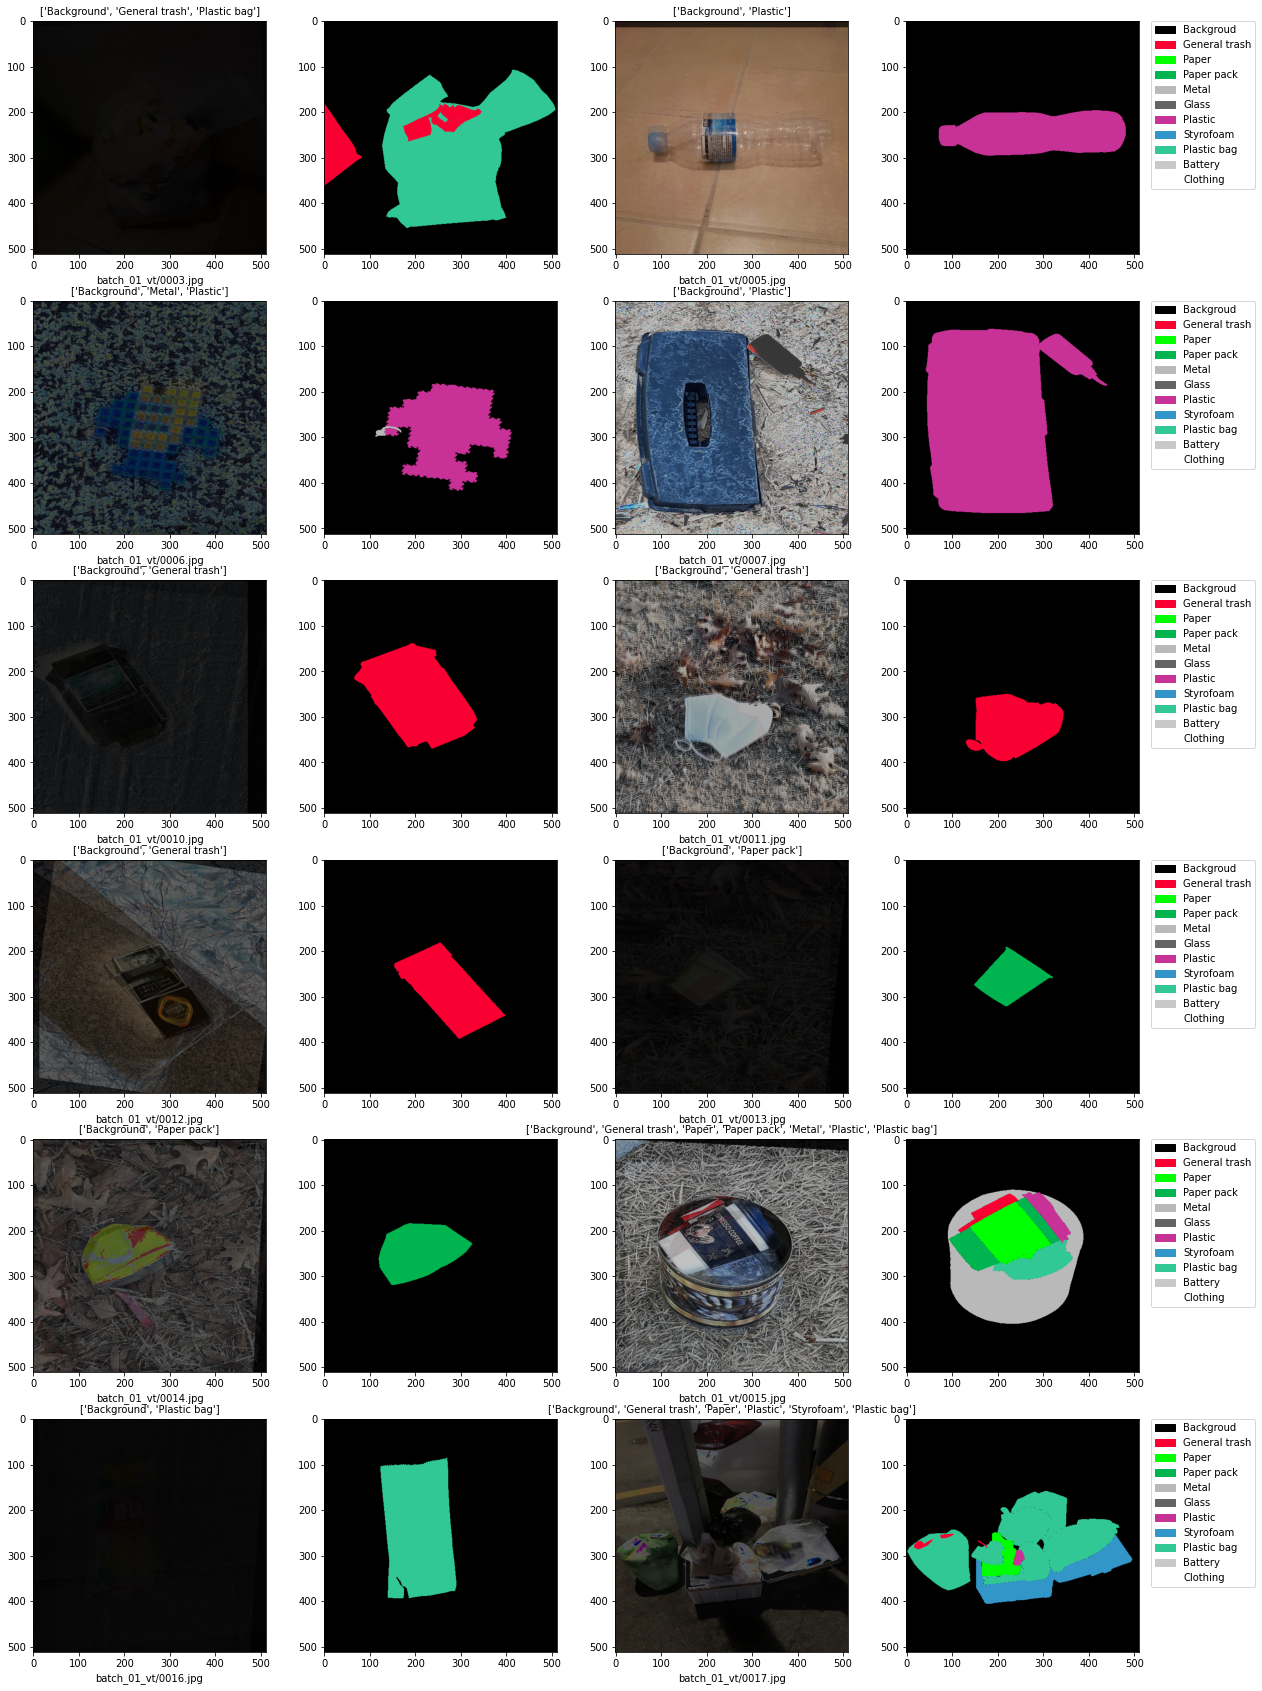

In [52]:

select_batch = 3

if not (0 <= select_batch < len(train_loader)):
    raise Exception("select_batch index error")


for i, (imgs, masks, image_infos) in enumerate(train_loader):

    category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
    legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                            edgecolor=webcolors.rgb_to_hex(rgb), 
                            label=category) for category, rgb in category_and_rgb]

    fig, ax = plt.subplots(nrows=6, ncols=4, figsize=(20, 30))
    # train_loader의 output 결과(image 및 mask) 확인
    for i in range(len(imgs)):

        temp_image_infos = image_infos[i]
        temp_images = imgs[i]
        temp_masks = masks[i]

        # ax[int(i//2),0 + (i%2)*2].imshow(temp_images)
        # ax[int(i//2),0 + (i%2)*2].grid(False)
        # ax[int(i//2),0 + (i%2)*2].set_title("{}".format([category_names[int(i)] for i in list(np.unique(temp_masks))]), fontsize = 10)
        # ax[int(i//2),0 + (i%2)*2].set_xlabel(temp_image_infos['file_name'])

        # ax[int(i//2),1 + (i%2)*2].imshow(label_to_color_image(temp_masks.detach().cpu().numpy()))
        # ax[int(i//2),1 + (i%2)*2].grid(False)
        # #ax[int(i//2),1 + (i%2)*2].set_title("{}".format([{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks))], fontsize = 5))
        # if (i%2)*2 == 2:
        #     ax[int(i//2),1 + (i%2)*2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
            
        
        ax[int(i//2),0 + (i%2)*2].imshow(temp_images.permute([1,2,0]))
        ax[int(i//2),0 + (i%2)*2].grid(False)
        ax[int(i//2),0 + (i%2)*2].set_title("{}".format([category_names[int(i)] for i in list(np.unique(temp_masks))]), fontsize = 10)
        ax[int(i//2),0 + (i%2)*2].set_xlabel(temp_image_infos['file_name'])

        ax[int(i//2),1 + (i%2)*2].imshow(label_to_color_image(temp_masks.detach().cpu().numpy()))
        ax[int(i//2),1 + (i%2)*2].grid(False)
        #ax[int(i//2),1 + (i%2)*2].set_title("{}".format([{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks))], fontsize = 5))
        if (i%2)*2 == 2:
            ax[int(i//2),1 + (i%2)*2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    break
    
plt.show()

# 원본 이미지

In [24]:
transforms_train = albumentations.Compose([
    # RandomAugMix(severity=3, width=3, p=1.),
    # albumentations.CenterCrop(p=1, height=300, width=300),
    ToTensorV2()
])

use_cuda = torch.cuda.is_available()
train_dataset = CustomDataLoader(data_dir='/opt/ml/segmentation/input/data/train.json', mode='train', transform=transforms_train)

# data_loader
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=12,
    num_workers=4,
    # shuffle=True,
    pin_memory=use_cuda,
    collate_fn=collate_fn,
    drop_last=True
)


loading annotations into memory...
Done (t=3.92s)
creating index...
index created!


<class 'torch.Tensor'>
<class 'torch.Tensor'>


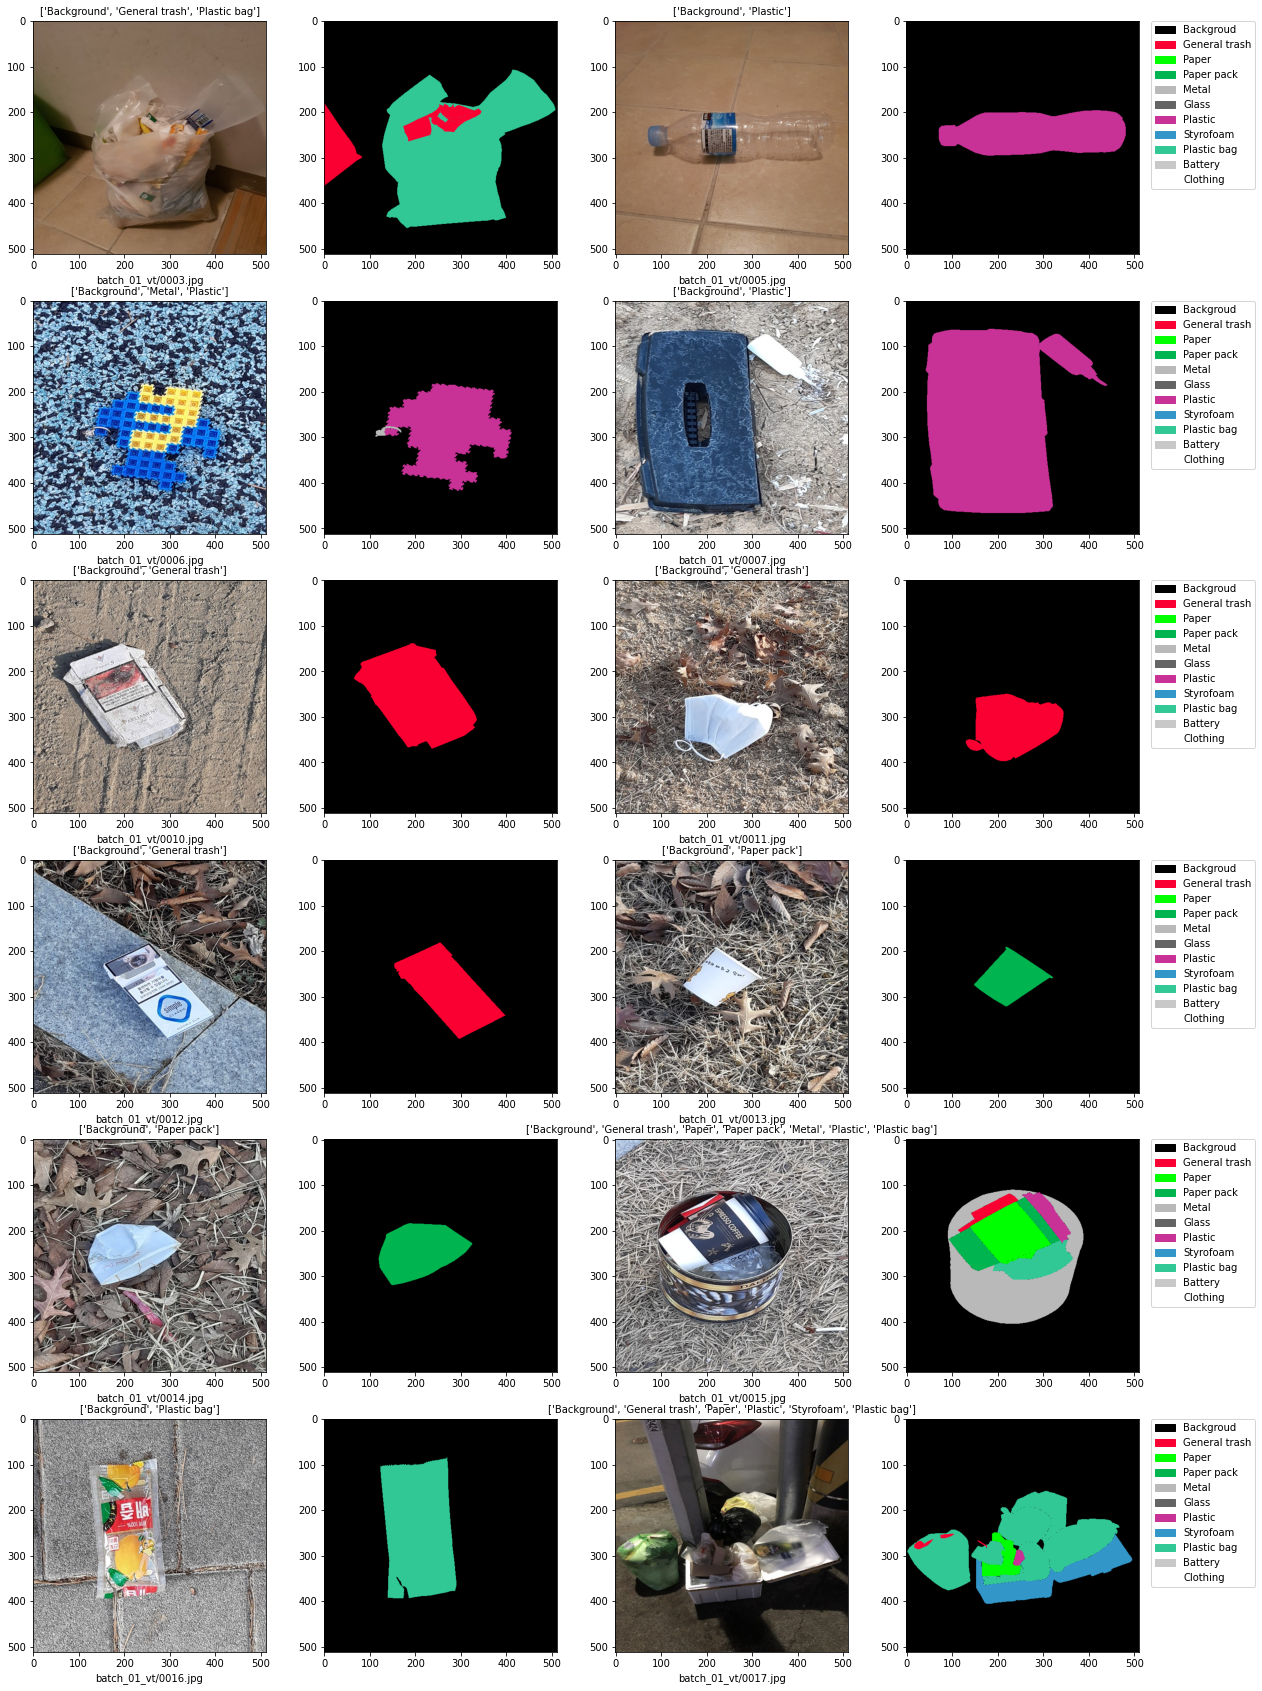

In [25]:

select_batch = 3

if not (0 <= select_batch < len(train_loader)):
    raise Exception("select_batch index error")


for i, (imgs, masks, image_infos) in enumerate(train_loader):

    category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
    legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                            edgecolor=webcolors.rgb_to_hex(rgb), 
                            label=category) for category, rgb in category_and_rgb]

    fig, ax = plt.subplots(nrows=6, ncols=4, figsize=(20, 30))
    # train_loader의 output 결과(image 및 mask) 확인
    for i in range(len(imgs)):
        temp_image_infos = image_infos[i]
        temp_images = imgs[i] 
        temp_masks = masks[i]

        temp_images = torch.from_numpy(temp_images)
        temp_masks = torch.from_numpy(temp_masks)

        
        ax[int(i//2),0 + (i%2)*2].imshow(temp_images)
        ax[int(i//2),0 + (i%2)*2].grid(False)
        ax[int(i//2),0 + (i%2)*2].set_title("{}".format([category_names[int(i)] for i in list(np.unique(temp_masks))]), fontsize = 10)
        ax[int(i//2),0 + (i%2)*2].set_xlabel(temp_image_infos['file_name'])

        ax[int(i//2),1 + (i%2)*2].imshow(label_to_color_image(temp_masks.detach().cpu().numpy()))
        ax[int(i//2),1 + (i%2)*2].grid(False)
        #ax[int(i//2),1 + (i%2)*2].set_title("{}".format([{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks))], fontsize = 5))
        if (i%2)*2 == 2:
            ax[int(i//2),1 + (i%2)*2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
            
        
        # ax[int(i//2),0 + (i%2)*2].imshow(temp_images.permute([1,2,0]))
        # ax[int(i//2),0 + (i%2)*2].grid(False)
        # ax[int(i//2),0 + (i%2)*2].set_title("{}".format([category_names[int(i)] for i in list(np.unique(temp_masks))]), fontsize = 10)
        # ax[int(i//2),0 + (i%2)*2].set_xlabel(temp_image_infos['file_name'])

        # ax[int(i//2),1 + (i%2)*2].imshow(label_to_color_image(temp_masks.detach().cpu().numpy()))
        # ax[int(i//2),1 + (i%2)*2].grid(False)
        # #ax[int(i//2),1 + (i%2)*2].set_title("{}".format([{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks))], fontsize = 5))
        # if (i%2)*2 == 2:
        #     ax[int(i//2),1 + (i%2)*2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    break
    
plt.show()